# Terrestrial Water Storage: Computing GRACE(-FO) basin averages and associated uncertainties from the JPL-Mascon data
#### written by: Felix Landerer (landerer@jpl.nasa.gov) and Munish Sikka (munish.sikka@jpl.nasa.gov); 
#### Version 1.0 [Aug-2023]
#### License: GPL-3.0-or-later

In [1]:
import time
from netCDF4 import Dataset, date2index
from datetime import datetime, date

import xarray as xr
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap
import shapefile
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import os

import sys
import os.path
import subprocess
import netCDF4
import math
import csv

#import s3fs
import copy
import json, copy
from pandas import DataFrame
from osgeo import gdal, ogr, osr

import grace_user_functions as grace_func

## Step 1: Load GRACE/GRACE-FO data and basin masks / shapefiles

In [2]:
start_date = "2002-04-01"
end_date = "2022-11-30"
# download the GRACE mascon dataset and use the absolute path in next line where it is kept in local file system
full_filename = 'GRACE_RESOURCES/GRCTellus.JPL.200204_202211.GLO.RL06.1M.MSCNv03CRI.nc'
dataset = xr.open_dataset((full_filename))

# read scale factors from the mascon dataset
scale_factor_xarray = dataset["scale_factor"]
scale_factor = scale_factor_xarray.to_numpy()

1.1 Take a look at the dataset contents that were just loaded:

In [3]:
dataset

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 215, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2022-11-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    land_mask      (lat, lon) float64 ...
    scale_factor   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    mascon_ID      (lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2023-01-30T07:01:56Z

1.2 Assign variables to compute water-equivalent heights:

In [4]:
lwe_thickness_subset = dataset["lwe_thickness"].sel(
    time=slice(start_date, end_date)).values
tdim, ydim, xdim = lwe_thickness_subset.shape

sig_lwe = dataset["uncertainty"].sel(
    time=slice(start_date, end_date)).values

1.3 Read a basin mask from a shape file (Note: other shapefiles can be used):

In [5]:
# link for shape file used in this script:
# https://www.bafg.de/SharedDocs/ExterneLinks/GRDC/wmobb_shp_zip.html?nn=201388 (shape file used in this code)
#place the shape file in local dir and use absoulte path 
shp = "GRACE_RESOURCES/wmobb_basins.shp"
layer_name = 'COLORADO (also COLORADO RIVER)'
[marr,bbox] = grace_func.read_shapefile_multilayers(shp,xdim,ydim,layer_name)
#Note: might return a warning/error message due to gdal bindings but not affecting rasterzation effort... fix TBD

ERROR 1: PROJ: proj_identify: Open of /opt/conda/share/proj failed


In [6]:
# mask and basin_area will be in N-S and -180 to 180 format. We need to shift , circroll to match it to GRACE(-FO) grid:
lat_vector = dataset.lat[:].copy()
lon_vector = dataset.lon[:].copy()
flip_lat = lat_vector[0] < lat_vector[-1]

data_res = abs(lon_vector[2 ] - lon_vector[1]) #resolution of dataset
indexes_to_shift = int(360 / (2 * data_res)) # no of global longitude divided by degree resolution; /2 gives mid point around which shift is done.

# determine if longitudes starts at 0 and goes to n then circshift or roll the grid and longitude array  
shift_lon = np.max(lon_vector) > 180

1.3.1 Compute weighted area for this region_mask

In [7]:
# The grid area associated with each grid is uniform in longitude. 
# We only need to calculate the grid area for one longitude.')
area_weights = grace_func.area(lat_vector.data).reshape(1,-1)
area_weights = np.transpose(area_weights)
no_of_lon = lon_vector.data.size
area_matrix = np.repeat(area_weights,no_of_lon,axis=1)

In [8]:
# apply mask on global area weights
basin_area = np.multiply(area_weights,marr)

In [9]:
region_mask = grace_func.shift_to_GRACE_orientation(shift_lon,flip_lat,marr,indexes_to_shift,1)
ma = grace_func.shift_to_GRACE_orientation(shift_lon,flip_lat,basin_area,indexes_to_shift,1)

## Step 2: Calculate mean over selected region

In [10]:
# apply scaling factor to lwe_thickness
lwe_thickness_scaled = np.empty(lwe_thickness_subset.shape)
regional_timeseries = np.empty(lwe_thickness_scaled.shape[0])
for time_index in range(0,len(regional_timeseries)):
    temp_lwe = lwe_thickness_subset[time_index,:,:]
    temp_lwe_scaled = np.multiply(temp_lwe,scale_factor)
    lwe_thickness_scaled[time_index,:,:] = temp_lwe_scaled
    #apply mask and compute area wighted mean work in progress
    mx = np.ma.masked_where(region_mask==0,temp_lwe_scaled, copy=True)
    regional_timeseries[time_index]=np.average(mx,weights=ma)

In [11]:
timesteps = dataset["time"].sel(
    time=slice(start_date, end_date)).values
plot_title_str = 'Terrestrial Water Storage over: ' + layer_name

## Step 3: plot basin-mean, and a map of the most recent monthly TWS anomaly map

(-15.0, 15.0)

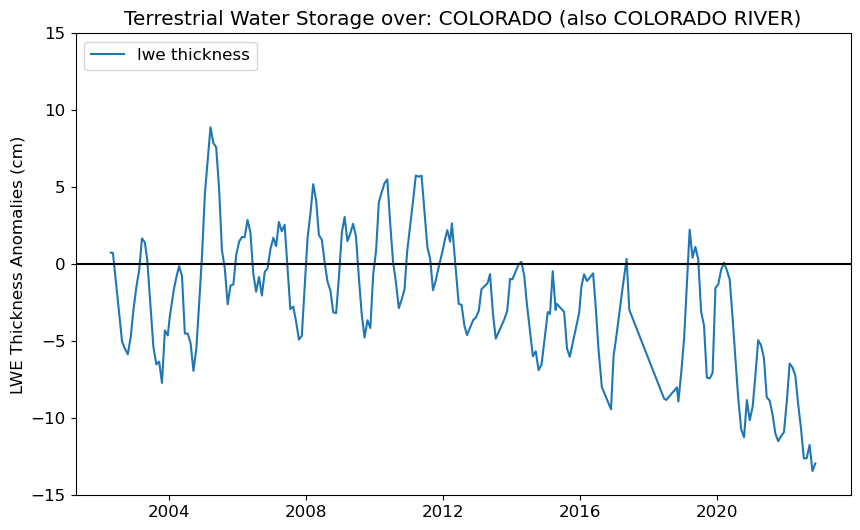

In [12]:
# plot monthly timeseries (#ref: https://unidata.github.io/python-training/workshop/Time_Series/basic-time-series-plotting/)
xmin = timesteps[0]
xmax = timesteps[-1]
ymin = -15
ymax = 15
yticks = np.arange(ymin, ymax+1,2)

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
# Specify how our lines should look
ax.plot(timesteps, regional_timeseries, color='tab:blue', label='lwe thickness')
plt.axhline(y = 0.0, color = 'black')
ax.set_ylabel('LWE Thickness Anomalies (cm)')
ax.set_title(plot_title_str)
ax.legend(loc='upper left');
ax.set_ylim([ymin, ymax])

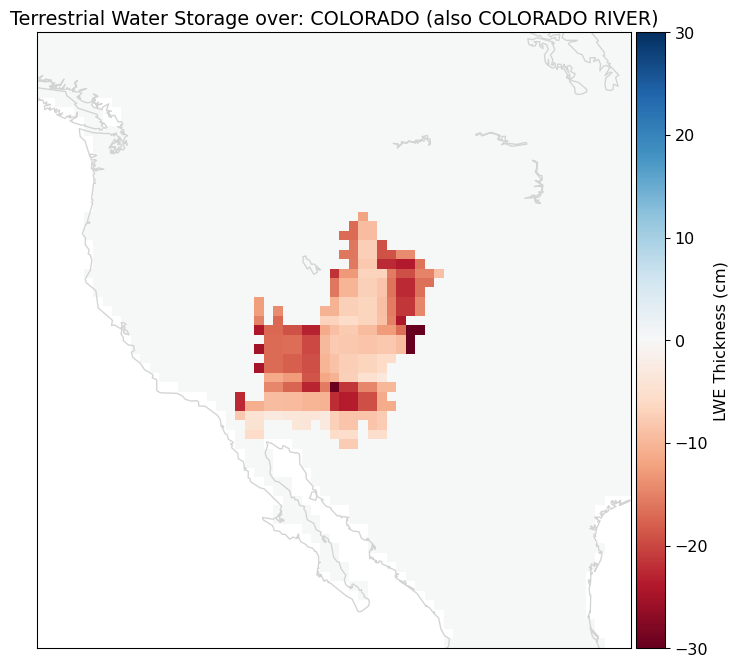

In [13]:
region_grid=np.multiply(lwe_thickness_scaled[-1,:,:],region_mask)
#plot the map of the region along with desired extent in the background
dpi = 96
fig = plt.figure(figsize=(1000 / dpi , 800 / dpi), dpi=dpi)

min_lon = bbox[0]-10 #displaying a buffer around the min and max lat,lon. 
min_lat = max(-90.0,bbox[1]-10) #capping at -90.0

max_lon = bbox[2]+10
max_lat = min(90.0,bbox[3]+10)  #capping at +90.0   

map = Basemap(projection='cyl', llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution='l')
map.drawcoastlines(color='lightgray')
ax = plt.gca()
ax.set_title(plot_title_str)

map.pcolormesh(lon_vector, lat_vector, region_grid, latlon=True, cmap='RdBu')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(label='LWE Thickness (cm)', cax=cax)
plt.clim(-30, 30)

#plt.savefig(output_plot_filename,  dpi=dpi)# in case we wish to save the plot

## Step 4: Uncertainty Estimate over the Region of Interest

#### Source: https://grace.jpl.nasa.gov/data/get-data/jpl_global_mascons/
#### For the JPL Mascons, measurement uncertainties are provided on a 0.5 degree grid in latitude and longitude for each monthly grid. Importantly, the uncertainties provided are the uncertainty values for EACH independent mascon, which are roughly 300km in spatial extent. Thus, there are only 4,551 independent estimates of uncertainty represented for each monthly grid over entire globe. This needs to be taken into account when computing the uncertainty of basin means.

#### The mascon IDs for points in our regional analysis in this tutorial are determined using file containing mascon IDs.

#### A detailed description of the uncertainty derivation is found in Wiese, Landerer and Watkins (2016). https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019344

In [14]:
#read the grid of mascon IDs from the mascon dataset
mascon_ID= dataset["mascon_ID"]
mscID=mascon_ID.to_numpy()

#### These gridded uncertainties are not the uncertainties associated with a single 0.5 degree pixel (which would be much higher!). 
#### To derive the scaled uncertainty estimates, we scale the formal covariance matrix over the ocean to match the error we see when comparing the GRACE/GRACE-FO data to in-situ ocean bottom pressure data. 
#### Over land, the formal uncertainty is scaled to roughly match uncertainty estimates that we derive using methods described in Wahr et al., (2006). 
#### The provided estimates of uncertainty are conservative. Since we implement a Kalman filter in our JPL-mascon solution process to link adjacent months together temporally, monthly solutions both at the very beginning and end of the time series have slightly larger uncertainties compared to monthly solutions in the middle of the time series. This also means that as the time series is extended with newer observations, the uncertainty estimates of recent months will change (typically: become smaller) as more data are added, until a floor is reached. Error estimates typically stabelize approx. 6 months away from the time series boundaries.

In [15]:
# find uncertainty values within the basin mask:
ma_t = np.transpose(ma)
non_zero_count = np.count_nonzero(ma>0)
bool_mask_t = ma_t!=0
new_sig_lwe_t = np.empty([sig_lwe.shape[0],non_zero_count])
for i in range(0,sig_lwe.shape[0]):
    temp_sig = sig_lwe[i,:,:]
    temp_sig_t = np.transpose(temp_sig)
    new_sig_lwe_t[i,:] = temp_sig_t[bool_mask_t]

In [16]:
mscID_t = np.transpose(mscID)
mscID_bsn = mscID_t[bool_mask_t]

In [17]:
ma_bsn = ma_t[bool_mask_t]

In [18]:
# find all unique mascon IDs within the basin mask:
C,ia,ic = np.unique(mscID_bsn,return_index=True ,return_inverse=True)

In [19]:
# loop around unique mscID values in basin to create uncertainty array for summing over unique mascons:
bsn_I = np.empty([len(C),len(mscID_bsn)])


In [20]:
for k in range(0,len(C)):
    bsn_I[k,:] = np.isin(mscID_bsn,C[k]);

In [21]:
# area-sum (via dot-product) of each unique mascon-area (not sig-lwe!) within the basin boundary:
maA = np.dot(bsn_I,ma_bsn)

In [22]:
# mass of mascon error for each mascon:
maA_matrix = np.tile(np.transpose(maA), [new_sig_lwe_t.shape[0], 1])
sig_lwe_ma = np.multiply(new_sig_lwe_t[:,ia] ,maA_matrix)

In [23]:
# RSS mascon errors; normalize by total area to get LWE:
bsn_sig = (np.sqrt(np.sum(np.square(sig_lwe_ma),axis=1)))/np.sum(maA)
#plot : lwe thickness and lwe_ + - bsn sig
# in case one wishes to save, edit the filename in next line and run
# np.savetxt('bsn_sig_riverbasin.csv', bsn_sig, delimiter=',')

In [24]:
under_line = regional_timeseries - bsn_sig
over_line = regional_timeseries + bsn_sig

(-15.0, 15.0)

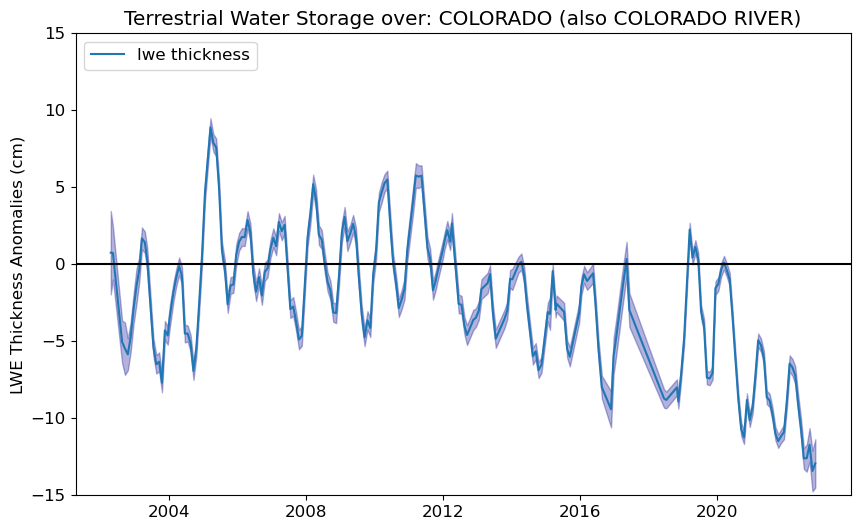

In [25]:
# plot monthly timeseries (#ref: https://unidata.github.io/python-training/workshop/Time_Series/basic-time-series-plotting/)
xmin = timesteps[0]
xmax = timesteps[-1]
ymin = -15
ymax = 15
yticks = np.arange(ymin, ymax+1,2)

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
# Specify how our lines should look
region_color='darkblue'
ax.plot(timesteps, regional_timeseries, color='tab:blue', label='lwe thickness')
ax.fill_between(timesteps, under_line, over_line, alpha=0.3, edgecolor=region_color, facecolor=region_color)

plt.axhline(y = 0.0, color = 'black')
ax.set_ylabel('LWE Thickness Anomalies (cm)')
ax.set_title(plot_title_str)
ax.legend(loc='upper left');
ax.set_ylim([ymin, ymax])